# Aplicando um classificador Multi-layer Perceptron em uma imagem e plotando o resultado com o Matplotlib

Neste notebook, utilizando o anterior, que trata da transformação de uma imagem em um DataFrame (estrutura de dados do Pandas), iremos aplicar um classificador Multi-layer Perceptron e plotar o resultado da classificação utilizando o Matplotlib.

Iremos extrair os dados de treinamento de uma imagem em uma data, utilizando para categorizar os dados o valor de threshold encontrado na literatura para o NDVI. Em uma outra data, iremos aplicar este classificador e analisar o resultado.

Primeiramente, vamos importar as bibliotecas e inicializar o GEE:

In [1]:
# importação da bibliotecas
import ee
import PIL
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# importação do sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

# inicialização do GEE
ee.Initialize() 

Funções principais utilizadas por esse notebook (comentadas nos notebooks anteriores):

In [2]:
# Função para aplicar à imagem vinda da coleção a máscara de água
def mascara_agua(imagem):
    qa = imagem.select('pixel_qa')
    return qa.bitwiseAnd(1 << 2).eq(0)

# Função para aplicar à imagem vinda da coléção a máscara de nuvem/sombra de nuvem
def mascara_nuvem(imagem):
    qa = imagem.select('pixel_qa')
    return qa.bitwiseAnd(1 << 3).eq(0) and (qa.bitwiseAnd(1 << 5).eq(0)) and (qa.bitwiseAnd(1 << 6).eq(0)) and (qa.bitwiseAnd(1 << 7).eq(0))

# função para aplicar as máscaras
def aplicar_mascaras(imagem):
    
    # criar uma imagem em branco/vazio para evitar problemas no fundo ao gerar um PNG
    # usamos valores dummies (neste caso, branco)
    vazio = ee.Image(99999)
    
    # máscara de água
    agua = vazio.updateMask(mascara_agua(imagem).Not()).rename('agua')
    
    # máscara de nuvem (criará uma imagem com apenas nuvens)
    # caso a imagem não tenha nuvens, ela ficará toda branca
    nuvem = vazio.updateMask(mascara_nuvem(imagem).Not()).rename('nuvem')
    
    # podemos ainda, ao contrário da linha anterior, REMOVER as nuvens
    # notem que retiramos a função .Not (negação)
    sem_nuvem = vazio.updateMask(mascara_nuvem(imagem)).rename('sem_nuvem')
    
    # aplicar o indice NDVI
    ndvi = imagem.expression('(nir - red) / (nir + red)',{'nir':imagem.select('B5'),'red':imagem.select('B4')}).rename('ndvi')
    
    # assim como fizemos para o NDVI, retornamos uma imagem com as novas bandas
    return imagem.addBands([ndvi,agua,nuvem,sem_nuvem])




# função para aplicar uma máscara em uma banda específica
def aplicar_mascara_banda(imagem, banda_mascara, banda_origem, band_destino):
    
    # Primeiramente, temos que aplicar a máscara desejada na banda de origem, que será nomeada para a banda de destino
    # Podemos, inclusive, sobscrever a banda de origem, sem problemas
    imagem_mascara = imagem.select(banda_origem).updateMask(imagem.select(banda_mascara)).rename(band_destino)
    
    # Depois, temos que criar uma imagem em branco que receberá a máscara, renomeando também para banda de destino
    imagem_mascara = ee.Image(99999).blend(imagem_mascara).rename(band_destino)
    
    # Retornar a imagem com a nova banda nomeada com a string da banda_destino
    return imagem.addBands([imagem_mascara])




# função para aplicar uma máscara a partir de imagem em uma banda específica
# função modificada para corrigir o problema do bitwise descartando anomalias em corpos d'água
def aplicar_mascara_banda_modificada(imagem, imagem_mascara, banda_origem, band_destino):
    
    # Primeiramente, temos que aplicar a máscara desejada na banda de origem, que será nomeada para a banda de destino
    # Podemos, inclusive, sobscrever a banda de origem, sem problemas
    imagem_mascara = imagem.select(banda_origem).updateMask(imagem_mascara).rename(band_destino)
    
    # Depois, temos que criar uma imagem em branco que receberá a máscara, renomeando também para banda de destino
    imagem_mascara = ee.Image(99999).blend(imagem_mascara).rename(band_destino)
    
    # Retornar a imagem com a nova banda nomeada com a string da banda_destino
    return imagem.addBands([imagem_mascara])




# Extrair as coordenadas e valores dos pixels de uma imagem
def extrair_latitude_longitude_pixel(imagem, geometria, bandas):
  
    # Inicialmente, devemos extrair as coordenadas por pixel da imagem
    # O GEE faz essa operação adicoinando uma banda com essas novas informações,
    # que extrairemos abaixo
    imagem = imagem.addBands(ee.Image.pixelLonLat())
    
    # Extraindo efetivament as coordenadas nas bandas recém criadas (latitude e longitude)
    # Nesta parte, é utilizado o que citamos como reducer (verifiar na documentação do GEE), mas ele permite que sejam feitas operações com uma imagem como: reduzi-la, modificar sua escala, etc.
    # ainda, os atributos utilizados são: geometry (geometria, mesma utilizada em outros exemplos), scale (escala do sensor, 30 metros no caso do Landsat), bestEffort (garante que a imagem terá a melhor escala possível, caso a definida seja muito grande para processamento)
    coordenadas = imagem.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=30,bestEffort=True)
    
    # ponteiro para incluir os valores dos pixeis de cada banda, já criando uma Numpy Array
    # o FOR abaixo irá percorrer cada banda que foi definida no parâmetro da função para extrair seus valores, um a um
    # As funções ee.List e getInfo() permitem transformar os pixeis em lista e depois extraí-los, respectivamente
    bandas_valores = []
    for banda in bandas:
        
        # adiciona pixel por pixel, em cada uma das bandas desejadas
        # transforma o valor do pixel em float para evitar erros de processamento futuros
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))
    
    
    # Retorna no forma de Numpy Array os dados separados pelas colunas [0,1,2..N BANDAS] sendo LATITUDE, LONGITUDE e VALOR DO PIXEL (POR BANDA...N BANDAS)
    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

Agora, vamos definir a geometria (baseada na Latitude e Longitude) e as datas da nossa área de estudo e consultá-la no GEE (mesmo do notebook anterior):

In [3]:
# Notem que foi criada uma coordenada (Latitude e Longitude) através de uma string, posteriormente repartida pelas virgulas
# Essa abordagem é importante para quando utilizarmos a linha da comando
coordenadas = "-48.53801472648439,-22.503806214013736,-48.270222978437516,-22.7281869567509"

# Aqui, usamos uma ferramenta do Python chamada de unpacking
x1,y1,x2,y2 = coordenadas.split(",")

# Criamos a geometria com base nas coordenadas 'quebradas' acima
geometria = geometry = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])

# String de datas
# Criamos aqui então duas datas: uma para treinar o método e outra para classificar
datas_treinamento = "2014-10-13,2014-10-14"
datas_classificacao = "2014-01-30,2014-01-31"

# Divisão das duas datas pela vírgula, novamente usando a técnica de unpacking
inicio_treinamento,fim_treinamento = datas_treinamento.split(",")
inicio_classificacao,fim_classificacao = datas_classificacao.split(",")

### Neste exemplo, faremos a extração do corpo d'água através de uma extensa serie temporal transformada em uma imagem mediana, a fim de corrigir um problema gerado com a operação bitwise. Como queremos classificar a floração de algas, se utilizarmos a extração da máscara de água apenas por ele, como ele quer apenas 'água', as florações de algas ficaram de foras e não estarão dentro da máscara.

### Portanto, que fazemos e criar uma extensa série temporal da área de estudo e geramos uma imagem mediana dela. Assim, fazemos a operação bitwise nesta imagem e depois usamos sua máscara nas outras com a função 'aplicar_mascara_banda_modificacada'

Diferente dos notebooks anteriores, precisamos ter duas imagens: uma para treinamento do método e outra para classificação.
Iremos então criar duas coleções para essa operação:

In [4]:
# Consultando a coleção com base na área de estudo e datas selecionadas
# Imagem para extração do corpo d'água
# Aqui, para gerar uma série temporal bem extensa, extendemos o filtro da data
colecao_mascara_agua = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(geometria).filterDate('2018-01-01','2020-01-01').filterMetadata('CLOUD_COVER','less_than', 30)
colecao_mascara_agua = colecao_mascara_agua.map(aplicar_mascaras)
imagem_mascara_agua = colecao_mascara_agua.median()

# Imagem de Treinamento
colecao_treinamento = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(geometria).filterDate(inicio_treinamento,fim_treinamento).filterMetadata('CLOUD_COVER','less_than', 30)
colecao_treinamento = colecao_treinamento.map(aplicar_mascaras)
imagem_treinamento = colecao_treinamento.median()

# Imagem de Classificação
colecao_classificacao = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(geometria).filterDate(inicio_classificacao,fim_classificacao).filterMetadata('CLOUD_COVER','less_than', 30)
colecao_classificacao = colecao_classificacao.map(aplicar_mascaras)
imagem_classificacao = colecao_classificacao.median()

Agora, vamos aplicar as máscaras individualmente na banda NDVI da imagem de treinamento:

In [5]:
# para corrigir o problema do bitwise ignorar anomalias em corpos d'água
mascara_agua = ee.Image(0).blend(ee.Image(99999).updateMask(imagem_mascara_agua.select('agua').gt(0))).eq(99999)
imagem_treinamento = aplicar_mascara_banda_modificada(imagem_treinamento, mascara_agua, 'ndvi', 'ndvi_agua')

# Depois, cortamos a imagem
# scale = escala do sensor. No caso do Landsat-8/OLI são 30 metros
imagem_corte_treinamento = imagem_treinamento.clipToBoundsAndScale(geometry=geometria,scale=30)
                                           
# Com a imagem, iremos extrair as coordenadas e o indice NDVI desejados, já com a máscara de água aplicada
# Usamos aqui novamente a técnica de unpacking (atentar para ordem: long,lat,indices)
longitudes, latitudes, indices = extrair_latitude_longitude_pixel(imagem_corte_treinamento, geometria, ['ndvi_agua'])

# Criando o Dataframe com as colunas desejadas
# Adicionamos os dados extraídos da imagem neste Dataframe, respeitando as colunas
# Usamos aqui a função zip, pra juntar as colunas, mantendo a relação de linhas (L1_COL1,L1_COL2,L1_COl3...L1_COLN)
# Existem outras maneiras de atingir o mesmo resultado
df_treinamento = pd.DataFrame(columns=['latitude','longitude', 'ndvi'],data=list(zip(latitudes,longitudes,indices[0])))

# Removendo os dummies
df_treinamento = df_treinamento[df_treinamento['ndvi'] != 99999]
print(df_treinamento.head())

      latitude  longitude      ndvi
601 -48.376030 -22.727961  0.732809
602 -48.375760 -22.727961  0.781153
603 -48.375491 -22.727961  0.867840
604 -48.375221 -22.727961  0.860184
605 -48.374952 -22.727961  0.802879


Vamos tambem aplicar as máscaras para a imagem que desejamos classificar:

In [6]:
# Nova forma de extrair a máscara de água a partir de uma imagem mediana de uma série temporal extensa
# para corrigir o problema do bitwise ignorar anomalias em corpos d'água
mascara_agua = ee.Image(0).blend(ee.Image(99999).updateMask(imagem_mascara_agua.select('agua').gt(0))).eq(99999)
imagem_classificacao = aplicar_mascara_banda_modificada(imagem_classificacao, mascara_agua, 'ndvi', 'ndvi_agua')

# Depois, cortamos a imagem
# scale = escala do sensor. No caso do Landsat-8/OLI são 30 metros
imagem_corte_classificacao = imagem_classificacao.clipToBoundsAndScale(geometry=geometria,scale=30)
                                           
# Com a imagem, iremos extrair as coordenadas e o indice NDVI desejados, já com a máscara de água aplicada
# Usamos aqui novamente a técnica de unpacking (atentar para ordem: long,lat,indices)
longitudes, latitudes, indices = extrair_latitude_longitude_pixel(imagem_corte_classificacao, geometria, ['ndvi_agua'])

# Criando o Dataframe com as colunas desejadas
# Adicionamos os dados extraídos da imagem neste Dataframe, respeitando as colunas
# Usamos aqui a função zip, pra juntar as colunas, mantendo a relação de linhas (L1_COL1,L1_COL2,L1_COl3...L1_COLN)
# Existem outras maneiras de atingir o mesmo resultado
df_classificacao = pd.DataFrame(columns=['latitude','longitude', 'ndvi'],data=list(zip(latitudes,longitudes,indices[0])))

# Removendo os dummies
df_classificacao = df_classificacao[df_classificacao['ndvi'] != 99999]
print(df_classificacao.head())

      latitude  longitude      ndvi
601 -48.376030 -22.727961  0.792484
602 -48.375760 -22.727961  0.739917
603 -48.375491 -22.727961  0.807908
604 -48.375221 -22.727961  0.868744
605 -48.374952 -22.727961  0.724376


In [7]:
# Estatísticas dos nossos dados
# Média dos dois conjuntos
print("Total do indice NDVI nos dados de treinamento: "+str(df_treinamento['ndvi'].mean()))
print("Total do indice NDVI nos dados de classificação: "+str(df_classificacao['ndvi'].mean()))

# Total de pixels
print("Total de pixels de treinamento: "+str(len(df_treinamento)))
print("Total de pixels de classificação: "+str(len(df_classificacao)))

Total do indice NDVI nos dados de treinamento: -0.10253990432780125
Total do indice NDVI nos dados de classificação: 0.3345043933911065
Total de pixels de treinamento: 155074
Total de pixels de classificação: 155074


Já temos os nossos DataFrames criados! Neste momento, precisamos categorizar nossos dados de treinamento com base no threshold do NDVI. Essa classificação será para floração de algas, respeitando a seguinte regra:

- 1 (floração de alga) se o valor do NDVI for maior ou igual a −0.15
- 0 (água) se o valor do NDVI for menor que -0.15

In [32]:
# Adicionando a coluna 'label' ao DataFrame de treinamento
df_treinamento['label'] = 0
df_treinamento.loc[df_treinamento['ndvi']>=-0.15,'label'] = 1

# Separando os dados de treinamento
# Definimos, por razões computacionais, que iremos utilizar apenas 20% dos dados para treinamento
# O restante será utilizado para medir a acurácia do modelo
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_treinamento['ndvi'].values.reshape(-1, 1), df_treinamento['label'].values, train_size=0.20, random_state=0)

Criamos abaixo o classificador e verificamos sua acurácia:

In [25]:
# Criando o classificador Multi-layer Perceptron
classificador = MLPClassifier(hidden_layer_sizes=(1), solver='lbfgs', max_iter=15, activation='logistic', learning_rate='constant', shuffle=True, random_state=0)
classificador.fit(X_train, y_train)
y_true, y_pred = y_test, classificador.predict(X_test)

# Acurácia do modelo
print(classification_report(y_true, y_pred, target_names=['água', 'floração de algas']))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


                   precision    recall  f1-score   support

             água       1.00      1.00      1.00     49158
floração de algas       1.00      1.00      1.00     74902

         accuracy                           1.00    124060
        macro avg       1.00      1.00      1.00    124060
     weighted avg       1.00      1.00      1.00    124060



Faremos agora a classificação da segunda imagem com o modelo criado:

In [26]:
# Adicionando a coluna 'label' ao DataFrame de classificação
df_classificacao['label'] = 0
df_classificacao.loc[df_classificacao['ndvi']>=-0.15,'label'] = 1

# Aplicando o classificador criado anteriormente
y_pred = classificador.predict(df_classificacao['ndvi'].values.reshape(-1, 1))

# Adicionar resultado da classificação
df_classificacao['classified'] = y_pred

# Acurácia do modelo
print(classification_report(df_classificacao['label'].values, y_pred, target_names=['água', 'floração de algas']))

                   precision    recall  f1-score   support

             água       1.00      1.00      1.00     17460
floração de algas       1.00      1.00      1.00    137614

         accuracy                           1.00    155074
        macro avg       1.00      1.00      1.00    155074
     weighted avg       1.00      1.00      1.00    155074



### Resultados da classificação

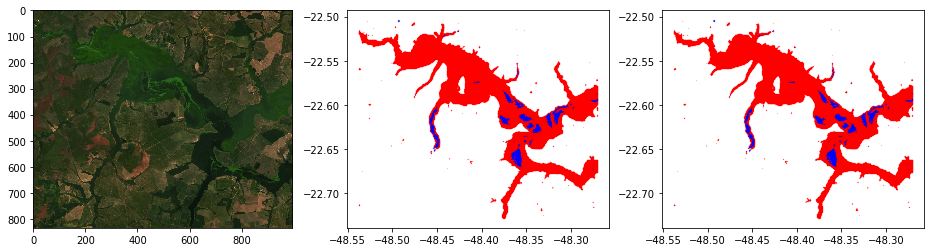

In [27]:
# Criação do grid da figura do Matplotlib
fig = plt.figure(figsize=(16,4))

# RGB
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(PIL.Image.open(BytesIO(requests.get(imagem_corte_classificacao.select(['B4','B3','B2']).getThumbUrl({'min':0, 'max':3000})).content)))

# Classificado usando Threshold
ax2 = fig.add_subplot(1,3,2)
ax2.plot(df_classificacao[df_classificacao['label']!=1]['latitude'], df_classificacao[df_classificacao['label']!=1]['longitude'], '.', color='blue', markersize=0.2)
ax2.plot(df_classificacao[df_classificacao['label']==1]['latitude'], df_classificacao[df_classificacao['label']==1]['longitude'], '.', color='red', markersize=0.2)

# Classificado pelo Multi-layer Perceptron
ax3 = fig.add_subplot(1,3,3)
ax3.plot(df_classificacao[df_classificacao['classified']!=1]['latitude'], df_classificacao[df_classificacao['classified']!=1]['longitude'], '.', color='blue', markersize=0.2)
ax3.plot(df_classificacao[df_classificacao['classified']==1]['latitude'], df_classificacao[df_classificacao['classified']==1]['longitude'], '.', color='red', markersize=0.2)

# Mostrar o gráfico
plt.show()